### Import Packages

In [1]:
import math
import pandas as pd
import numpy as np
import requests

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt

### Import Training Data

In [2]:
train_data = pd.read_csv("C:\\Users\\13996\\PycharmProjects\\AMS518\\Titanic\\train.csv")
train_dataorg = train_data.copy()  #save the original train_data 

### Import Testing Data

In [3]:
test_data = pd.read_csv("C:\\Users\\13996\\PycharmProjects\\AMS518\\Titanic\\test.csv")
test_dataorg = test_data.copy()  #save the original test_data 

## ****Data Cleaning****

### Dealing with Missing Data

##### Count how many missing data in the training data set

In [4]:
train_miss = train_data.isnull().sum()
print(train_miss)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Convert Sex to numerical 

In [5]:
le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])

### Testing Correlations between each features


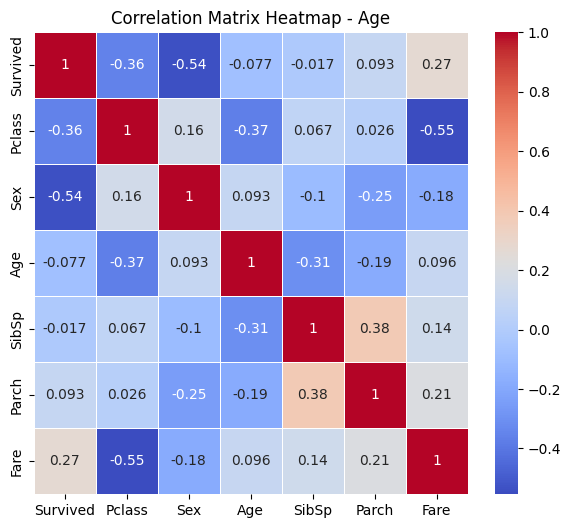

In [6]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]

# Only select rows without missing Age values
age_notna = train_data[train_data['Age'].notna()]

age_data = age_notna[features]
agg_corr = age_data.corr()

#Plot the HeatMap
plt.figure(figsize=(7, 6))
sns.heatmap(agg_corr , annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap - Age')
plt.show()

### Age

##### The highest correlated feature with Age is the Pclass. I fill the missing values by the median of the age by Pclass. 

In [7]:
#deal with missing value in Age
median_ages = train_data.groupby(train_data['Pclass'])['Age'].transform('median')
train_data['Age'] = train_data['Age'].fillna(median_ages)

##### Break down the Age to Child(0-17), Adult(18-64), Senior(65+) as new features

In [8]:
train_data['Child'] = train_data['Age'].apply(lambda x: 1 if x < 18 else 0)
train_data['Adult'] = train_data['Age'].apply(lambda x: 1 if x>= 18 and x < 65 else 0)
train_data['Senior'] = train_data['Age'].apply(lambda x: 1 if x>= 65 else 0)

### Cabin

##### Deal With Missing value in Cabin, replace the cabin with 1st letter and fill in NaN with "U", add a new feature to defined Cabin is Unknown (1) known (0). 

In [9]:
#Deal With Missing value in Cabin, replace the cabin with 1st letter and fill in NaN with "U", add a new feature to defined Cabin is Unknown (1) known (0)
#later we will use new features instead of the features with missing values
train_data['Cabin_letter'] = train_data['Cabin'].str[0].fillna("U")
train_data['Cabin_check'] = train_data["Cabin"].isna().astype(int)

### Name

##### Break down Feature Name based on their Title, saved as new features

In [10]:
names = train_data['Name'].unique()
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).str.strip()
titlecheck = train_data['Title'].unique()
titlecheck

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [11]:
#Repalce the unsure title as Unknown, and others based on the information
replacements = {
        'Don': 'Unknown',
        'Rev': 'Unknown',
        'Dr': 'Unknown',
        'Mme': 'Mrs/Miss',
        'Ms': 'Mrs/Miss',
        'Major': 'Unknown',
        'Lady': 'Mrs/Miss',
        'Sir': 'Mr',
        'Mlle': 'Unknown',
        'Col': 'Unknown',
        'Capt': 'Unknown',
        'The Countess': 'Unknown',
        'Jonkheer': 'Mr'
}

train_data['Title'] = train_data['Title'].replace(replacements)
train_data["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Unknown', 'Mrs/Miss',
       'the Countess'], dtype=object)

### Fare

##### Break down the Fare: Low(0-14.45), Standard(14.45-31), Premium(31+) as new features

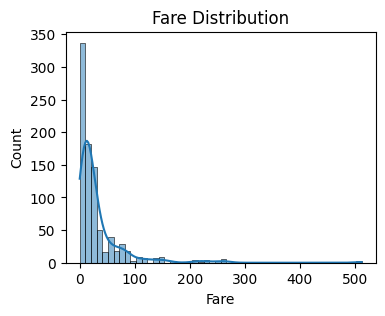

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [12]:
#check the statistics of Fare
plt.figure(figsize=(4, 3))
sns.histplot(train_data['Fare'], bins=50, kde=True)
plt.title('Fare Distribution')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()
train_data['Fare'].describe()

In [13]:
#Add new features based on Fare
train_data['Fare_low'] = train_data['Fare'].apply(lambda x: 1 if x < 14.45 else 0)
train_data['Fare_standard'] = train_data['Fare'].apply(lambda x: 1 if x>= 14.45 and x < 31 else 0)
train_data['Fare_premium'] = train_data['Fare'].apply(lambda x: 1 if x>= 31 else 0)

### Embarked

##### Replace missing values with the most frequent Embarked data, (mode)

In [14]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], axis=0)

In [15]:
train_data['Embarked']

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

### Ticket

##### Add New feature based on Ticket, 'Tickect_dig' if the Ticket is all digits return 1 else 0 

In [16]:
train_data['Ticket_dig'] = train_data['Ticket'].str.isdigit().astype(int)

In [17]:
#Check all the features
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    int32  
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       891 non-null    object 
 12  Child          891 non-null    int64  
 13  Adult          891 non-null    int64  
 14  Senior         891 non-null    int64  
 15  Cabin_letter   891 non-null    object 
 16  Cabin_check    891 non-null    int32  
 17  Title          891 non-null    object 
 18  Fare_low  

### Convert non-numerical to numerical 

In [18]:
train_data['Cabin_letter'] = le.fit_transform(train_data['Cabin_letter'])
train_data['Title'] = le.fit_transform(train_data['Title'])
train_data['Embarked'] = le.fit_transform(train_data['Embarked'])
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    int32  
 5   Age            891 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       891 non-null    int32  
 12  Child          891 non-null    int64  
 13  Adult          891 non-null    int64  
 14  Senior         891 non-null    int64  
 15  Cabin_letter   891 non-null    int32  
 16  Cabin_check    891 non-null    int32  
 17  Title          891 non-null    int32  
 18  Fare_low  

In [19]:
feature_names = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked", "Cabin_letter","Cabin_check","Title","Child","Adult","Senior","Fare_low","Fare_standard","Fare_premium","Ticket_dig"]
train_data = pd.get_dummies(train_data[feature_names])
train_data

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Cabin_letter,Cabin_check,Title,Child,Adult,Senior,Fare_low,Fare_standard,Fare_premium,Ticket_dig
0,0,3,1,1,0,2,8,1,2,0,1,0,1,0,0,0
1,1,1,0,1,0,0,2,0,3,0,1,0,0,0,1,0
2,1,3,0,0,0,2,8,1,1,0,1,0,1,0,0,0
3,1,1,0,1,0,2,2,0,3,0,1,0,0,0,1,1
4,0,3,1,0,0,2,8,1,2,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,2,8,1,5,0,1,0,1,0,0,1
887,1,1,0,0,0,2,1,0,1,0,1,0,0,1,0,1
888,0,3,0,1,2,2,8,1,1,0,1,0,0,1,0,0
889,1,1,1,0,0,0,2,0,2,0,1,0,0,1,0,1


### We use training set to do Cross-validation 4-folds

In [20]:
kf = KFold(n_splits=4, shuffle=True, random_state=42) #break up tp 4 folds
subsets = []
for train_index, test_index in kf.split(train_data):
    subsets.append(train_data.iloc[test_index].reset_index(drop=True)) #assign each folds
subset_1 = subsets[0]
subset_2 = subsets[1]
subset_3 = subsets[2]
subset_4 = subsets[3]

In [21]:
# Set 1
X_in_1 = pd.concat([subset_1, subset_2, subset_3], axis=0) 
X_out_1 = subset_4


# Set 2
X_in_2 = pd.concat([subset_2, subset_3, subset_4], axis=0)
X_out_2 = subset_1


# Set 3 
X_in_3 = pd.concat([subset_1, subset_3, subset_4], axis=0)
X_out_3 = subset_2


# Set 4
X_in_4 = pd.concat([subset_1, subset_2, subset_4], axis=0)
X_out_4 = subset_3


##### Preparing x_train, y_train

In [22]:
#set 1
x_train1 = X_in_1.drop(['Survived'], axis=1)
y_train1 = X_in_1['Survived']

x_test1 = X_out_1.drop(['Survived'], axis=1)
y_test1 = X_out_1['Survived']


#set 2
x_train2 = X_in_2.drop(['Survived'], axis=1)
y_train2 = X_in_2['Survived']

x_test2 = X_out_2.drop(['Survived'], axis=1)
y_test2 = X_out_2['Survived']


#set 3
x_train3 = X_in_3.drop(['Survived'], axis=1)
y_train3 = X_in_3['Survived']

x_test3 = X_out_3.drop(['Survived'], axis=1)
y_test3 = X_out_3['Survived']


#set 4
x_train4 = X_in_4.drop(['Survived'], axis=1)
y_train4 = X_in_4['Survived']

x_test4 = X_out_4.drop(['Survived'], axis=1)
y_test4 = X_out_4['Survived']


### Method 1: Random Forest

In [23]:
rf_in_acc = []
rf_out_acc = []
for i in range(1, 5): 
    x_train = eval(f'x_train{i}')
    y_train = eval(f'y_train{i}')
    x_test = eval(f'x_test{i}')
    y_test = eval(f'y_test{i}')

    rf = RandomForestClassifier(n_estimators=1000, random_state=42,max_depth=5) #build 1000 decision trees
    rf.fit(x_train, y_train)

    y_fit = rf.predict(x_train)
    y_pred = rf.predict(x_test)

    acc_train = accuracy_score(y_train, y_fit)
    acc_test = accuracy_score(y_test, y_pred)
    
    rf_in_acc.append(acc_train)
    rf_out_acc.append(acc_test)

    print(f"=== Dataset {i} ===")
    print("Random Forest Train Accuracy:", acc_train)
    print("Random Forest Test Accuracy:", acc_test)
    print()

rf_in_avg = (rf_in_acc[0] + rf_in_acc[1] + rf_in_acc[2] + rf_in_acc[3]) / 4
rf_out_avg = (rf_out_acc[0] + rf_out_acc[1] + rf_out_acc[2] + rf_out_acc[3] ) / 4
print("Average Random Forest Train Accuracy: " + str(rf_in_avg))
print("Average Random Forest Test Accuracy: " + str(rf_out_avg))

=== Dataset 1 ===
Random Forest Train Accuracy: 0.8579970104633782
Random Forest Test Accuracy: 0.8198198198198198

=== Dataset 2 ===
Random Forest Train Accuracy: 0.8607784431137725
Random Forest Test Accuracy: 0.8026905829596412

=== Dataset 3 ===
Random Forest Train Accuracy: 0.8637724550898204
Random Forest Test Accuracy: 0.8340807174887892

=== Dataset 4 ===
Random Forest Train Accuracy: 0.8488023952095808
Random Forest Test Accuracy: 0.820627802690583

Average Random Forest Train Accuracy: 0.8578375759691379
Average Random Forest Test Accuracy: 0.8193047307397082


### Method 2: XGboost

In [24]:
xg_in_acc = []
xg_out_acc = []
for i in range(1, 5):  
    x_train = eval(f'x_train{i}')
    y_train = eval(f'y_train{i}')
    x_test = eval(f'x_test{i}')
    y_test = eval(f'y_test{i}')
    
    xg = XGBClassifier(n_estimators=1000, learning_rate=0.01)
    xg.fit(x_train, y_train)

    y_fit = xg.predict(x_train)
    y_pred = xg.predict(x_test)

    acc_train = accuracy_score(y_train, y_fit)
    acc_test = accuracy_score(y_test, y_pred)

    xg_in_acc.append(acc_train)
    xg_out_acc.append(acc_test)
    
    print(f"=== Dataset {i} ===")
    print("XGboost Train Accuracy:", acc_train)
    print("XGboost Test Accuracy:", acc_test)
    print()
xg_in_avg = (xg_in_acc[0] + xg_in_acc[1] + xg_in_acc[2] + xg_in_acc[3]) / 4
xg_out_avg = (xg_out_acc[0] + xg_out_acc[1] + xg_out_acc[2] + xg_out_acc[3] ) / 4
print("Average XGboost Train Accuracy: " + str(xg_in_avg))
print("Average XGboost Test Accuracy: " + str(xg_out_avg))

=== Dataset 1 ===
XGboost Train Accuracy: 0.8774289985052317
XGboost Test Accuracy: 0.8243243243243243

=== Dataset 2 ===
XGboost Train Accuracy: 0.8877245508982036
XGboost Test Accuracy: 0.8161434977578476

=== Dataset 3 ===
XGboost Train Accuracy: 0.8922155688622755
XGboost Test Accuracy: 0.8116591928251121

=== Dataset 4 ===
XGboost Train Accuracy: 0.8892215568862275
XGboost Test Accuracy: 0.7982062780269058

Average XGboost Train Accuracy: 0.8866476687879846
Average XGboost Test Accuracy: 0.8125833232335474


### Method 3 LightGBM

In [25]:
lg_in_acc = []
lg_out_acc = []
for i in range(1, 5):  
    x_train = eval(f'x_train{i}')
    y_train = eval(f'y_train{i}')
    x_test = eval(f'x_test{i}')
    y_test = eval(f'y_test{i}')
    
    lg = LGBMClassifier()
    lg.fit(x_train, y_train)

    y_fit = lg.predict(x_train)
    y_pred = lg.predict(x_test)

    acc_train = accuracy_score(y_train, y_fit)
    acc_test = accuracy_score(y_test, y_pred)

    lg_in_acc.append(acc_train)
    lg_out_acc.append(acc_test)
    
    print(f"=== Dataset {i} ===")
    print("LightGBM Train Accuracy:", acc_train)
    print("LightGBM Test Accuracy:", acc_test)
    print()
lg_in_avg = (lg_in_acc[0] + lg_in_acc[1] + lg_in_acc[2] + lg_in_acc[3]) / 4
lg_out_avg = (lg_out_acc[0] + lg_out_acc[1] + lg_out_acc[2] + lg_out_acc[3] ) / 4
print("Average LightGBM Train Accuracy: " + str(lg_in_avg))
print("Average LightGBM Test Accuracy: " + str(lg_out_avg))

[LightGBM] [Info] Number of positive: 260, number of negative: 409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 669, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.388640 -> initscore=-0.453034
[LightGBM] [Info] Start training from score -0.453034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [26]:
print("Average Random Forest Train Accuracy: " + str(rf_in_avg))
print("Average Random Forest Test Accuracy: " + str(rf_out_avg))

print("Average XGboost Train Accuracy: " + str(xg_in_avg))
print("Average XGboost Test Accuracy: " + str(xg_out_avg))

print("Average LightGBM Train Accuracy: " + str(lg_in_avg))
print("Average LightGBM Test Accuracy: " + str(lg_out_avg))

Average Random Forest Train Accuracy: 0.8578375759691379
Average Random Forest Test Accuracy: 0.8193047307397082
Average XGboost Train Accuracy: 0.8866476687879846
Average XGboost Test Accuracy: 0.8125833232335474
Average LightGBM Train Accuracy: 0.8825320211594747
Average LightGBM Test Accuracy: 0.8159516018260413


### Testing the Result by using the Testing Data

In [27]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Cleaning the Data and add featuers (same as the train_data)

In [28]:
#check missing values
test_miss = test_data.isnull().sum()
print(test_miss)
print("==============================================")
#Fill missing value in Fare with most common one
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mode()[0], axis=0)

#Convert Sex to numerical
test_data['Sex'] = le.fit_transform(test_data['Sex'])

#Replace missing value in Age
median_ages_test = test_data.groupby(test_data['Pclass'])['Age'].transform('median')
test_data['Age'] = test_data['Age'].fillna(median_ages_test)
#Break down Ages
test_data['Child'] = test_data['Age'].apply(lambda x: 1 if x < 18 else 0)
test_data['Adult'] = test_data['Age'].apply(lambda x: 1 if x>= 18 and x < 65 else 0)
test_data['Senior'] = test_data['Age'].apply(lambda x: 1 if x>= 65 else 0)

#In test_data Cabin contains multiple values!!!!!!!!! Only take the first one, because the letter is always the same
test_data['Cabin'] = test_data['Cabin'].str.split().str[0]
#Create new features for Cabin
test_data['Cabin_letter'] = test_data['Cabin'].str[0].fillna("U")
test_data['Cabin_check'] = test_data["Cabin"].isna().astype(int)
#Convert Cabin_letter to numerical
test_data['Cabin_letter'] = le.fit_transform(test_data['Cabin_letter'])


#Add new features based on Name
names_test = test_data['Name'].unique()
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).str.strip()
titlecheck_test = test_data['Title'].unique()
print(titlecheck_test)
print("==============================================")
#Repalce the unsure title as Unknown, and others based on the information
replacements_test = {
        'Don': 'Unknown',
        'Rev': 'Unknown',
        'Dr': 'Unknown',
        'Mme': 'Mrs/Miss',
        'Ms': 'Mrs/Miss',
        'Major': 'Unknown',
        'Lady': 'Mrs/Miss',
        'Sir': 'Mr',
        'Mlle': 'Unknown',
        'Col': 'Unknown',
        'Capt': 'Unknown',
        'The Countess': 'Unknown',
        'Jonkheer': 'Mr',
        'Dona': 'Unknown'
}

test_data['Title'] = test_data['Title'].replace(replacements_test)
print(test_data["Title"].unique())
#Convert Cabin_letter to numerical
test_data['Title'] = le.fit_transform(test_data['Title'])

#Add new features based on Fare
test_data['Fare_low'] = test_data['Fare'].apply(lambda x: 1 if x < 14.45 else 0)
test_data['Fare_standard'] = test_data['Fare'].apply(lambda x: 1 if x>= 14.45 and x < 31 else 0)
test_data['Fare_premium'] = test_data['Fare'].apply(lambda x: 1 if x>= 31 else 0)

#Add new features based on Ticket
test_data['Ticket_dig'] = test_data['Ticket'].str.isdigit().astype(int)

#Convert Embarked to numerical
test_data['Embarked'] = le.fit_transform(test_data['Embarked'])

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']
['Mr' 'Mrs' 'Miss' 'Master' 'Mrs/Miss' 'Unknown']


In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    int32  
 4   Age            418 non-null    float64
 5   SibSp          418 non-null    int64  
 6   Parch          418 non-null    int64  
 7   Ticket         418 non-null    object 
 8   Fare           418 non-null    float64
 9   Cabin          91 non-null     object 
 10  Embarked       418 non-null    int32  
 11  Child          418 non-null    int64  
 12  Adult          418 non-null    int64  
 13  Senior         418 non-null    int64  
 14  Cabin_letter   418 non-null    int32  
 15  Cabin_check    418 non-null    int32  
 16  Title          418 non-null    int32  
 17  Fare_low       418 non-null    int64  
 18  Fare_stand

In [30]:
feature_names_test = ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Cabin_letter","Cabin_check","Title","Child","Adult","Senior","Fare_low","Fare_standard","Fare_premium","Ticket_dig"]
testing_data =  pd.get_dummies(test_data[feature_names_test])
testing_data

,Pclass,Sex,SibSp,Parch,Embarked,Cabin_letter,Cabin_check,Title,Child,Adult,Senior,Fare_low,Fare_standard,Fare_premium,Ticket_dig
0,3,1,0,0,1,7,1,2,0,1,0,1,0,0,1
1,3,0,1,0,2,7,1,3,0,1,0,1,0,0,1
2,2,1,0,0,1,7,1,2,0,1,0,1,0,0,1
3,3,1,0,0,2,7,1,2,0,1,0,1,0,0,1
4,3,0,1,1,2,7,1,3,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,0,0,2,7,1,2,0,1,0,1,0,0,0
414,1,0,0,0,0,2,0,5,0,1,0,0,0,1,0
415,3,1,0,0,2,7,1,2,0,1,0,1,0,0,0
416,3,1,0,0,2,7,1,2,0,1,0,1,0,0,1


### Result by using Method 1: Random Forest

In [31]:
rfpred = rf.predict(testing_data)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': rfpred})
output.to_csv('v2rfsubmission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Result by using Method 2: XGboost

In [32]:
xgpred = xg.predict(testing_data)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': xgpred})
output.to_csv('v2xgsubmission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Result by using Method 3: LightGBM 

In [33]:
lgpred = lg.predict(testing_data)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': lgpred})
output.to_csv('v2lgsubmission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Accuracy for all three methods is improved to 0.78229